In [1]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
shared_filepath = '/content/drive/MyDrive/Data/'

In [4]:
filepath = '/content/drive/MyDrive/cs523/'

In [45]:
path_train = shared_filepath+"train"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [5]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 20405


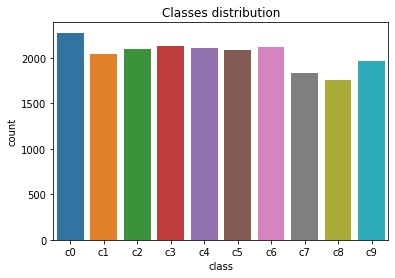

In [47]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [ ]:
##separating train into train and test into folders 

In [6]:
##for inception v3 trial

transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [72]:
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.9*total_len)
val_len = total_len - training_len

training_data,val_data = torch.utils.data.random_split(data,(training_len,val_len))

In [50]:
training_len

18364

In [51]:
val_len

2041

In [7]:
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla V100-SXM2-16GB


In [73]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

In [74]:
model_ft = models.inception_v3(pretrained=True)

# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 10)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
def model_train(model, criterion, optimizer, scheduler, n_epochs = 30):
    
    losses = []
    accuracies = []
    val_accuracies = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
            
            _, pred = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()
     
            running_loss += loss.item()
            running_correct += (labels==pred).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        val_acc = model_val(model)
        val_accuracies.append(val_acc)
        torch.save(model.state_dict(), filepath+'Inception_V3/model_inception_epoch{}.pth'.format(epoch+1)) 
     
        model.train()
        scheduler.step(val_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, val_accuracies

In [79]:
def model_val(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
  
            outputs = model_ft(images)
            _, pred = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (pred == labels).sum().item()

    val_acc = 100.0 * correct / total
    print('Accuracy on validation images: %d %%' % (
        val_acc))
    return val_acc

In [80]:
model_ft, training_losses, training_accs, test_accs = model_train(model_ft, criterion, optimizer, lrscheduler, n_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 183 s, loss: 1.0681, acc: 73.9003
Accuracy on validation images: 82 %


  3%|▎         | 1/30 [03:21<1:37:30, 201.73s/it]

Epoch 2, duration: 182 s, loss: 0.6048, acc: 85.3386
Accuracy on validation images: 89 %


  7%|▋         | 2/30 [06:44<1:34:27, 202.40s/it]

Epoch 3, duration: 181 s, loss: 0.4711, acc: 88.7358
Accuracy on validation images: 89 %


 10%|█         | 3/30 [10:04<1:30:33, 201.25s/it]

Epoch 4, duration: 182 s, loss: 0.4094, acc: 90.0316
Accuracy on validation images: 90 %


 13%|█▎        | 4/30 [13:24<1:27:00, 200.80s/it]

Epoch 5, duration: 180 s, loss: 0.3622, acc: 91.3001
Accuracy on validation images: 90 %


 17%|█▋        | 5/30 [16:45<1:23:44, 200.97s/it]

Epoch 6, duration: 183 s, loss: 0.2918, acc: 92.9061
Accuracy on validation images: 93 %


 20%|██        | 6/30 [20:07<1:20:31, 201.30s/it]

Epoch 7, duration: 183 s, loss: 0.2475, acc: 93.9188
Accuracy on validation images: 94 %


 23%|██▎       | 7/30 [23:31<1:17:25, 201.98s/it]

Epoch 8, duration: 186 s, loss: 0.2231, acc: 94.4305
Accuracy on validation images: 94 %


 27%|██▋       | 8/30 [26:58<1:14:38, 203.55s/it]

Epoch 9, duration: 185 s, loss: 0.2199, acc: 94.5013
Accuracy on validation images: 95 %


 30%|███       | 9/30 [30:21<1:11:11, 203.43s/it]

Epoch 10, duration: 183 s, loss: 0.2175, acc: 94.5285
Accuracy on validation images: 95 %


 33%|███▎      | 10/30 [33:42<1:07:37, 202.88s/it]

Epoch 11, duration: 182 s, loss: 0.2036, acc: 94.9260
Accuracy on validation images: 94 %


 37%|███▋      | 11/30 [37:03<1:04:02, 202.26s/it]

Epoch 12, duration: 180 s, loss: 0.2101, acc: 94.8715
Accuracy on validation images: 94 %


 40%|████      | 12/30 [40:24<1:00:30, 201.68s/it]

Epoch 13, duration: 181 s, loss: 0.2093, acc: 94.8062
Accuracy on validation images: 94 %


 43%|████▎     | 13/30 [43:43<56:57, 201.01s/it]  

Epoch 14, duration: 181 s, loss: 0.2052, acc: 95.0076
Accuracy on validation images: 95 %


 47%|████▋     | 14/30 [47:03<53:30, 200.68s/it]

Epoch 15, duration: 182 s, loss: 0.2083, acc: 94.9151
Accuracy on validation images: 94 %


 50%|█████     | 15/30 [50:24<50:12, 200.85s/it]

Epoch 16, duration: 184 s, loss: 0.2086, acc: 94.8007
Accuracy on validation images: 94 %


 53%|█████▎    | 16/30 [53:47<46:59, 201.39s/it]

Epoch 17, duration: 184 s, loss: 0.2096, acc: 94.8443
Accuracy on validation images: 94 %


 57%|█████▋    | 17/30 [57:12<43:54, 202.65s/it]

Epoch 18, duration: 182 s, loss: 0.2084, acc: 94.7409
Accuracy on validation images: 94 %


 60%|██████    | 18/30 [1:00:33<40:24, 202.04s/it]

Epoch 19, duration: 185 s, loss: 0.2025, acc: 95.1492
Accuracy on validation images: 95 %


 63%|██████▎   | 19/30 [1:03:58<37:12, 202.91s/it]

Epoch 20, duration: 186 s, loss: 0.2054, acc: 94.8770
Accuracy on validation images: 94 %


 67%|██████▋   | 20/30 [1:07:23<33:54, 203.47s/it]

Epoch 21, duration: 188 s, loss: 0.2069, acc: 94.7463
Accuracy on validation images: 95 %


 70%|███████   | 21/30 [1:10:51<30:43, 204.81s/it]

Epoch 22, duration: 186 s, loss: 0.1983, acc: 95.0621
Accuracy on validation images: 95 %


 73%|███████▎  | 22/30 [1:14:15<27:17, 204.66s/it]

Epoch 23, duration: 188 s, loss: 0.2083, acc: 94.8606
Accuracy on validation images: 95 %


 77%|███████▋  | 23/30 [1:17:45<24:04, 206.34s/it]

Epoch 24, duration: 187 s, loss: 0.2067, acc: 94.9532
Accuracy on validation images: 94 %


 80%|████████  | 24/30 [1:21:11<20:36, 206.11s/it]

Epoch 25, duration: 188 s, loss: 0.2073, acc: 94.9423
Accuracy on validation images: 95 %


 83%|████████▎ | 25/30 [1:24:39<17:13, 206.72s/it]

Epoch 26, duration: 187 s, loss: 0.2075, acc: 94.7681
Accuracy on validation images: 95 %


 87%|████████▋ | 26/30 [1:28:05<13:45, 206.43s/it]

Epoch 27, duration: 186 s, loss: 0.2053, acc: 94.9260
Accuracy on validation images: 94 %


 90%|█████████ | 27/30 [1:31:29<10:17, 205.80s/it]

Epoch 28, duration: 179 s, loss: 0.1986, acc: 95.0294
Accuracy on validation images: 95 %


 93%|█████████▎| 28/30 [1:34:46<06:46, 203.25s/it]

Epoch 29, duration: 180 s, loss: 0.2139, acc: 94.6919
Accuracy on validation images: 95 %


 97%|█████████▋| 29/30 [1:38:05<03:21, 201.75s/it]

Epoch 30, duration: 179 s, loss: 0.1997, acc: 95.0675
Accuracy on validation images: 95 %


100%|██████████| 30/30 [1:41:22<00:00, 202.75s/it]

Finished Training


In [81]:
training_accs

[73.90026132404181,
 85.33863240418118,
 88.73584494773519,
 90.03157665505226,
 91.30008710801394,
 92.90614111498257,
 93.91877177700349,
 94.43053135888502,
 94.50130662020906,
 94.52852787456446,
 94.92595818815332,
 94.87151567944251,
 94.80618466898954,
 95.0076219512195,
 94.91506968641114,
 94.80074041811847,
 94.84429442508711,
 94.74085365853658,
 95.1491724738676,
 94.87695993031359,
 94.74629790940766,
 95.06206445993031,
 94.86062717770035,
 94.95317944250871,
 94.94229094076655,
 94.76807491289199,
 94.92595818815332,
 95.02939895470384,
 94.69185540069687,
 95.06750871080139]

In [82]:
test_accs

[82.41058304752572,
 89.36795688388045,
 89.26996570308673,
 90.78882900538952,
 90.29887310142087,
 93.9735423811857,
 94.31651151396375,
 94.56148946594807,
 95.14943655071043,
 95.29642332190103,
 94.95345418912298,
 94.31651151396375,
 94.6594806467418,
 95.68838804507594,
 94.90445859872611,
 94.56148946594807,
 94.61048505634493,
 94.70847623713865,
 95.63939245467908,
 94.85546300832925,
 95.39441450269476,
 95.83537481626654,
 95.34541891229789,
 94.70847623713865,
 95.10044096031358,
 95.10044096031358,
 94.12052915237629,
 95.0514453699167,
 95.39441450269476,
 95.59039686428221]

<Figure size 432x288 with 0 Axes>

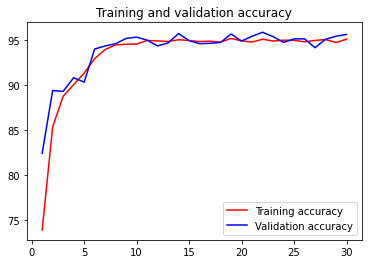

<Figure size 432x288 with 0 Axes>

In [85]:
plt.plot(range(1,31), training_accs, 'r', label='Training accuracy')
plt.plot(range(1,31), test_accs, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

**Testing**

In [8]:
model = models.inception_v3()

# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 10)
# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [9]:
##load the model which we chose where there was no overfitting
model.load_state_dict(torch.load(filepath+"Inception_V3/model_inception_epoch14.pth"))
model.eval()
model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
path_test = shared_filepath+"TestData"

In [13]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            #predicted = torch.max(outputs, 1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [14]:
testing_data = datasets.ImageFolder(root = path_test, transform = transform)

total_test_len = len(testing_data)

In [15]:
testing_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)

In [19]:
y_true,y_pred = true_pred(testing_loader,model)

100%|██████████| 64/64 [05:56<00:00,  5.57s/it]


**Performance Metrics**

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7464091134224864

In [17]:

precision = precision_score(y_true,y_pred, pos_label='positive',average='micro')
print('Precision: ', precision)

Precision:  0.7464091134224864


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [19]:

f1 = f1_score(y_true,y_pred, pos_label='positive',average='micro')
print('F1 score: ', f1)

F1 score:  0.7464091134224865


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [20]:

recallscore = recall_score(y_true,y_pred, pos_label='positive',average='micro')
print('Recall score: ', recallscore)

Recall score:  0.7464091134224864


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [31]:
from sklearn.metrics import classification_report
final_repo = classification_report(y_true, y_pred, zero_division=1,target_names = list(class_dict.values()))
print(final_repo)

                              precision    recall  f1-score   support

                safe driving       0.47      0.70      0.56       214
             texting - right       0.74      0.84      0.79       224
talking on the phone - right       0.81      0.90      0.85       221
              texting - left       0.91      0.80      0.85       220
 talking on the phone - left       0.79      0.79      0.79       223
         operating the radio       0.87      0.82      0.85       226
                    drinking       0.71      0.87      0.78       203
             reaching behind       0.85      0.91      0.88       169
             hair and makeup       0.74      0.52      0.61       159
        talking to passenger       0.68      0.12      0.20       160

                    accuracy                           0.75      2019
                   macro avg       0.76      0.73      0.72      2019
                weighted avg       0.76      0.75      0.73      2019



In [32]:
def topk_pred(test_data,model,k):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.topk(model(x), k).indices
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    positivecount = 0
    for i in range(len(y_true)):
      if y_true[i] in y_pred[i]:
        positivecount += 1

    return positivecount/len(y_true)

In [33]:
top2_acc = topk_pred(testing_loader,model,2)

100%|██████████| 64/64 [00:18<00:00,  3.52it/s]


In [34]:
top2_acc

0.8172362555720654

**Confusion Matrix**

In [21]:
m = confusion_matrix(y_true, y_pred)
m  = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

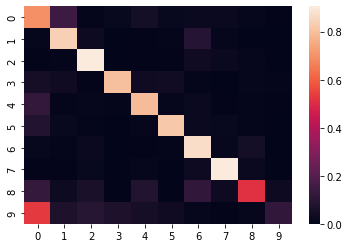

In [22]:
sns.heatmap(m)